In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda

## 유동인구

**성연령**

In [2]:
age = eda.flow_concat('AGE','../data/01_SKT/*.csv')
age = eda.flow_preprocessing(age)
age = eda.flow_melting(age)
age['AGE_CD'] = age['VAR'].apply(lambda x: x[-3:] if x[-4] == '_' else x[-4:])
age['SEX_CD'] = age['VAR'].str[0].map({'M':'M', 'W':'F'})
age = age[['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'POP_CNT']]
age_dict = {x: int(x[:2])for x in sorted(age['AGE_CD'].unique())}
age['AGE_CD'] = age['AGE_CD'].map(age_dict)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 20 if x < 20 else x)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 65 if x > 65 else x)
age = age.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD']) \
         [['POP_CNT']].sum().reset_index()
print(age.shape)
age.head()

(332580, 6)


,STD_YMD,GU_NM,HDONG_NM,SEX_CD,AGE_CD,POP_CNT
0,2019-02-01,대구 수성구,고산1동,F,20,8940.65
1,2019-02-01,대구 수성구,고산1동,F,25,3686.51
2,2019-02-01,대구 수성구,고산1동,F,30,3505.06
3,2019-02-01,대구 수성구,고산1동,F,35,5378.35
4,2019-02-01,대구 수성구,고산1동,F,40,6873.14


**날짜별 동별 그룹핑(성별, 나이 상관없이)**

**시간**

In [3]:
time = eda.flow_concat('TIME','../data/01_SKT/*.csv')
time = eda.flow_preprocessing(time)
time = eda.flow_melting(time, var_name='TM')
time['TM'] = time['TM'].apply(lambda x: x[-2:])
print(time.shape)
time.head()

(382467, 5)


,STD_YMD,GU_NM,HDONG_NM,TM,POP_CNT
0,2019-02-01,서울 중구,소공동,01,1022.83
1,2019-02-01,서울 중구,회현동,01,1117.26
2,2019-02-01,서울 중구,명동,01,1726.10
3,2019-02-01,서울 중구,필동,01,440.70
4,2019-02-01,서울 중구,장충동,01,447.23


**날짜, 구, 행정동으로 그룹핑(성별, 나이, 시간대 변수 제외)**

In [4]:
tr_age = age.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['POP_CNT'].sum().reset_index()
print(tr_age.shape)
tr_age.head()

(16629, 4)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT
0,2019-02-01,대구 수성구,고산1동,133361.08
1,2019-02-01,대구 수성구,고산2동,254912.57
2,2019-02-01,대구 수성구,고산3동,57764.08
3,2019-02-01,대구 수성구,두산동,125647.42
4,2019-02-01,대구 수성구,만촌1동,132277.61


In [5]:
tr_time = time.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['POP_CNT'].sum().reset_index()
print(tr_time.shape)
tr_time.head()

(16629, 4)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT
0,2019-02-01,대구 수성구,고산1동,132119.98
1,2019-02-01,대구 수성구,고산2동,252527.81
2,2019-02-01,대구 수성구,고산3동,57192.22
3,2019-02-01,대구 수성구,두산동,123689.09
4,2019-02-01,대구 수성구,만촌1동,130920.70


**두 테이블간 오차가 있으므로 더 정확한 계산을 위해 평균을 적용**

In [6]:
tr_flow = pd.concat([tr_age, tr_time])
tr_flow = tr_flow.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['POP_CNT'] \
                 .mean().reset_index()
print(tr_flow.shape)
tr_flow.head()

(16629, 4)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT
0,2019-02-01,대구 수성구,고산1동,132740.530
1,2019-02-01,대구 수성구,고산2동,253720.190
2,2019-02-01,대구 수성구,고산3동,57478.150
3,2019-02-01,대구 수성구,두산동,124668.255
4,2019-02-01,대구 수성구,만촌1동,131599.155


**sns데이터와 행정동을 맞추기 위해 1,2,3,...동으로 나누어진 행정동을 하나의 동으로 통합**

In [7]:
hd_flow = eda.hdong_integrated(tr_flow)
print(hd_flow.shape)
hd_flow.head()

(288, 4)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT
0,2019-02-01,대구 수성구,고산동,11469906.22
1,2019-02-01,대구 수성구,두산동,3123238.44
2,2019-02-01,대구 수성구,만촌동,6114767.56
3,2019-02-01,대구 수성구,범물동,1703146.98
4,2019-02-01,대구 수성구,범어동,7923682.43


**감염병데이터와 결합을 위해 구 단위로 그룹핑**

In [8]:
ep_flow = tr_flow.groupby(['STD_YMD', 'GU_NM'])['POP_CNT'].sum().reset_index()
print(ep_flow.shape)
ep_flow.head()

(964, 3)


,STD_YMD,GU_NM,POP_CNT
0,2019-02-01,대구 수성구,1889737.440
1,2019-02-01,대구 중구,863156.130
2,2019-02-01,서울 노원구,1695635.500
3,2019-02-01,서울 중구,2040498.255
4,2019-02-02,대구 수성구,1797497.145


## 카드매출

**내국인**

In [9]:
resid = pd.read_csv('../data/02_Shinhan_Card/shinhan_dataset(내국인).txt', sep='\t')
resid = eda.card_preprocessing(resid)
resid.rename(columns={'STD_DD':'STD_YMD', 'DONG_NM':'HDONG_NM'}, inplace=True)
resid = resid.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD']) \
             [['USE_CNT', 'USE_AMT']].sum().dropna().reset_index()
resid['USE_CNT'] = resid['USE_CNT'].astype('int')
resid['USE_AMT'] = resid['USE_AMT'].astype('int')
print(resid.shape)
resid.head()

(331976, 7)


,STD_YMD,GU_NM,HDONG_NM,SEX_CD,AGE_CD,USE_CNT,USE_AMT
0,2019-02-01,대구 수성구,고산1동,F,20,634,8206
1,2019-02-01,대구 수성구,고산1동,F,25,680,11416
2,2019-02-01,대구 수성구,고산1동,F,30,502,10644
3,2019-02-01,대구 수성구,고산1동,F,35,691,15472
4,2019-02-01,대구 수성구,고산1동,F,40,983,23233


**외국인**

In [10]:
fore = pd.read_csv('../data/02_Shinhan_Card/shinhan_dataset(외국인).txt', sep='\t',
                   encoding='cp949')
fore = eda.card_preprocessing(fore)
fore.rename(columns={'STD_DD':'STD_YMD', 'DONG_NM':'HDONG_NM'}, inplace=True)
fore[fore['USE_AMT'].isnull() & fore['USE_CNT'] == 1] = \
fore[fore['USE_AMT'].isnull() & fore['USE_CNT'] == 1].fillna(58)
fore[fore['USE_AMT'].isnull()] = fore[fore['USE_AMT'].isnull()].fillna(365)
fore['USE_AMT'] = fore['USE_AMT'].astype('int')
print(fore.shape)
fore.head()

(238829, 7)


,STD_YMD,GU_NM,HDONG_NM,UP_NM,COUNTRY_NM,USE_CNT,USE_AMT
0,2019-02-04,대구 수성구,범어1동,음료식품,대만,2,30
1,2019-02-13,대구 수성구,범어1동,유통업,대만,2,32
2,2019-04-16,대구 수성구,범어1동,유통업,대만,2,16
3,2019-04-19,대구 수성구,범어1동,의복,대만,3,610
4,2019-03-08,대구 수성구,범어1동,숙박,대만,7,629


**카드매출 종합**

In [11]:
tr_resid = resid.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])[['USE_CNT', 'USE_AMT']] \
         .sum().reset_index()
tr_fore = fore.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])[['USE_CNT', 'USE_AMT']] \
        .sum().reset_index()

In [12]:
sales = pd.concat([tr_resid, tr_fore]).groupby(['STD_YMD', 'GU_NM', 'HDONG_NM']) \
          [['USE_CNT', 'USE_AMT']].sum().reset_index()
print(sales.shape)
sales.head()

(16629, 5)


,STD_YMD,GU_NM,HDONG_NM,USE_CNT,USE_AMT
0,2019-02-01,대구 수성구,고산1동,15389,412037
1,2019-02-01,대구 수성구,고산2동,11548,387103
2,2019-02-01,대구 수성구,고산3동,12774,336823
3,2019-02-01,대구 수성구,두산동,15480,683605
4,2019-02-01,대구 수성구,만촌1동,12039,544981


## SNS

In [13]:
network = pd.read_csv('../data/03_Wisenut/wisenut_dataset.csv', encoding='utf-8',
                      sep='\x07')
network = eda.initial_preprocessing(network)

**채널**

In [14]:
channel = eda.sns_melting(network, ['NEWS', 'BLOG', 'CAFE'])
channel = eda.sns_preprocessing(channel,
                                {'NEWS':'뉴스', 'BLOG':'블로그', 'CAFE':'카페'},
                                colname='CHNL_NM')
print(channel.shape)
channel.head()

(840, 5)


,STD_YMD,GU_NM,HDONG_NM,CHNL_NM,CNT
0,2019-02-01,서울 중구,소공동,뉴스,4
1,2019-02-01,서울 중구,회현동,뉴스,4
2,2019-02-01,서울 중구,명동,뉴스,6
3,2019-02-01,서울 중구,필동,뉴스,0
4,2019-02-01,서울 중구,장충동,뉴스,13


**화제어**

In [15]:
topic = eda.sns_melting(network, 'TOPIC', value_name='TOPIC')
topic = eda.sns_preprocessing(topic, value_name='TOPIC')
print(topic.shape)
topic.head()

(280, 4)


,STD_YMD,GU_NM,HDONG_NM,TOPIC
0,2019-02-01,서울 중구,소공동,"장관,기념식,창간,롯데호텔,뷔페"
1,2019-02-01,서울 중구,회현동,"회현동,서울역,도시재생,윤동주,일제강점기"
2,2019-02-01,서울 중구,명동,"생활유산,열쇠고리,신세계백화점,리뉴얼,관광객"
3,2019-02-01,서울 중구,필동,"저작권,영남상생포럼,자유한국장,지적,그랜드호텔"
4,2019-02-01,서울 중구,장충동,"빵집,태극당,신라호텔,세관,감사원"


**게시물**

In [16]:
post = eda.sns_melting(network, ['POSITIVE', 'NEGATIVE'])
post = eda.sns_preprocessing(post,
                             {'UP1':'숙박', 'UP2':'레저업소', 'UP3':'문화취미',
                              'UP4':'의료기관', 'UP5':'보건위생', 'UP6':'요식업소'},
                             colname='UP_NM')
print(post.shape)
post.head()

(3360, 5)


,STD_YMD,GU_NM,HDONG_NM,UP_NM,CNT
0,2019-02-01,서울 중구,소공동,숙박,5
1,2019-02-01,서울 중구,회현동,숙박,13
2,2019-02-01,서울 중구,명동,숙박,106
3,2019-02-01,서울 중구,필동,숙박,32
4,2019-02-01,서울 중구,장충동,숙박,29


## 유통

In [17]:
logistics = pd.read_excel('../data/04_GS_Retail/gs_dataset.xlsx',
                          sheet_name='TB_DD_STR_PURCH_CLS',
                          parse_dates=['OPER_DT'])
logistics['BOR'] = logistics['PVN'].str[:2] + ' ' + logistics['BOR']
logistics.rename(columns={'OPER_DT':'STD_YMD', 'BOR':'GU_NM', 'ADMD':'HDONG_NM'},
                 inplace=True)
index = logistics[['STD_YMD', 'GU_NM', 'HDONG_NM', 'AMT_IND']]
print(index.shape)
index.head()

(14460, 4)


,STD_YMD,GU_NM,HDONG_NM,AMT_IND
0,2019-02-01,대구 수성구,고산1동,1.064336
1,2019-02-01,대구 수성구,고산2동,1.076418
2,2019-02-01,대구 수성구,고산3동,0.856071
3,2019-02-01,대구 수성구,두산동,0.724868
4,2019-02-01,대구 수성구,만촌1동,1.155728


In [19]:
index = index.assign(DAW=index['STD_YMD'].apply(lambda x:x.day_name()))

In [20]:
index = index.set_index('STD_YMD')

In [21]:
total = index.iloc[index.index != '2020-02-29'][['AMT_IND', 'DAW']]

In [28]:
last_mon = total.loc[:'2019-05-31'].query('DAW == "Monday"')['AMT_IND']
this_mon = total.loc['2020-02-01':].query('DAW == "Monday"')['AMT_IND']
this_mon.index = (this_mon.index - pd.DateOffset(years=1))

last_tue = total.loc[:'2019-05-31'].query('DAW == "Tuesday"')['AMT_IND']
this_tue = total.loc['2020-02-01':].query('DAW == "Tuesday"')['AMT_IND']
this_tue.index = (this_tue.index - pd.DateOffset(years=1))

last_wed = total.loc[:'2019-05-31'].query('DAW == "Wednesday"')['AMT_IND']
this_wed = total.loc['2020-02-01':].query('DAW == "Wednesday"')['AMT_IND']
this_wed.index = (this_wed.index - pd.DateOffset(years=1))

last_thu = total.loc[:'2019-05-31'].query('DAW == "Thursday"')['AMT_IND']
this_thu = total.loc['2020-02-01':].query('DAW == "Thursday"')['AMT_IND']
this_thu.index = (this_thu.index - pd.DateOffset(years=1))

last_fri = total.loc[:'2019-05-31'].query('DAW == "Friday"')['AMT_IND']
this_fri = total.loc['2020-02-01':].query('DAW == "Friday"')['AMT_IND']
this_fri.index = (this_fri.index - pd.DateOffset(years=1))

last_sat = total.loc[:'2019-05-31'].query('DAW == "Saturday"')['AMT_IND']
this_sat = total.loc['2020-02-01':].query('DAW == "Saturday"')['AMT_IND']
this_sat.index = (this_sat.index - pd.DateOffset(years=1))

last_sun = total.loc[:'2019-05-31'].query('DAW == "Sunday"')['AMT_IND']
this_sun = total.loc['2020-02-01':].query('DAW == "Sunday"')['AMT_IND']
this_sun.index = (this_sun.index - pd.DateOffset(years=1))

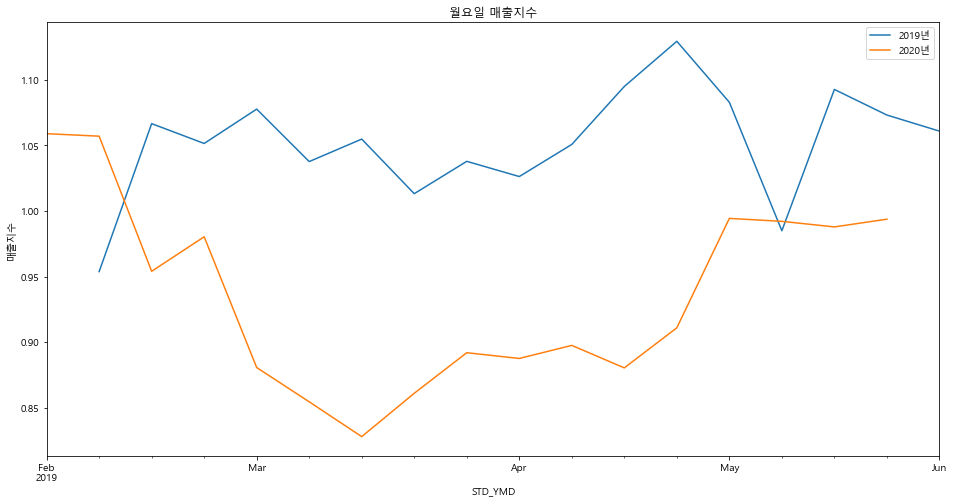

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
last_mon.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_mon.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('월요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

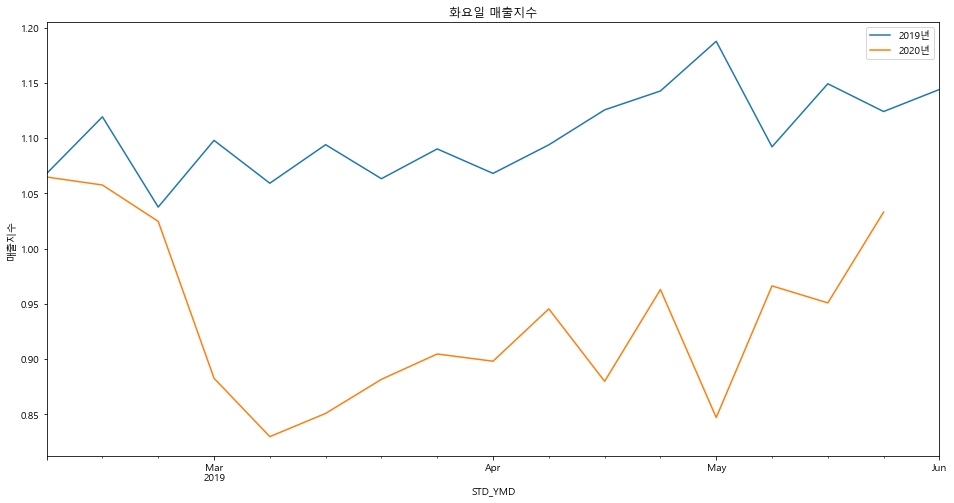

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
last_tue.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_tue.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('화요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

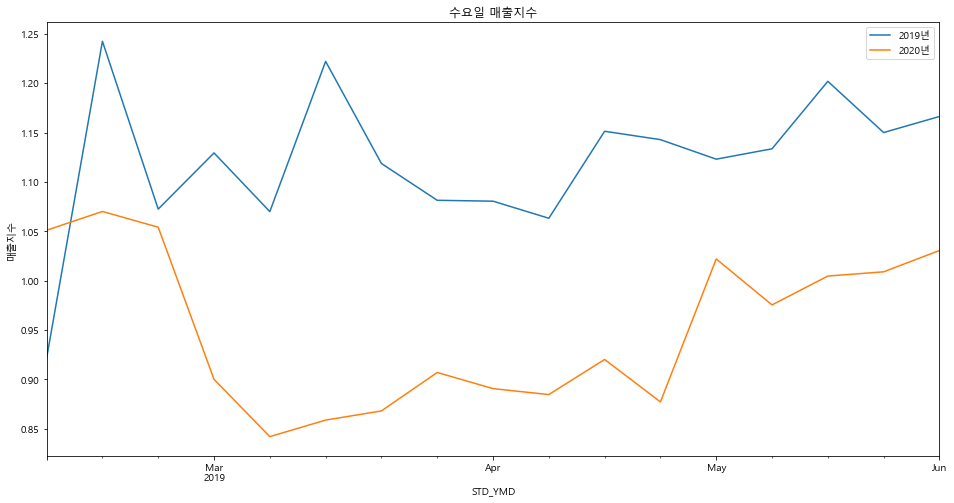

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
last_wed.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_wed.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('수요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

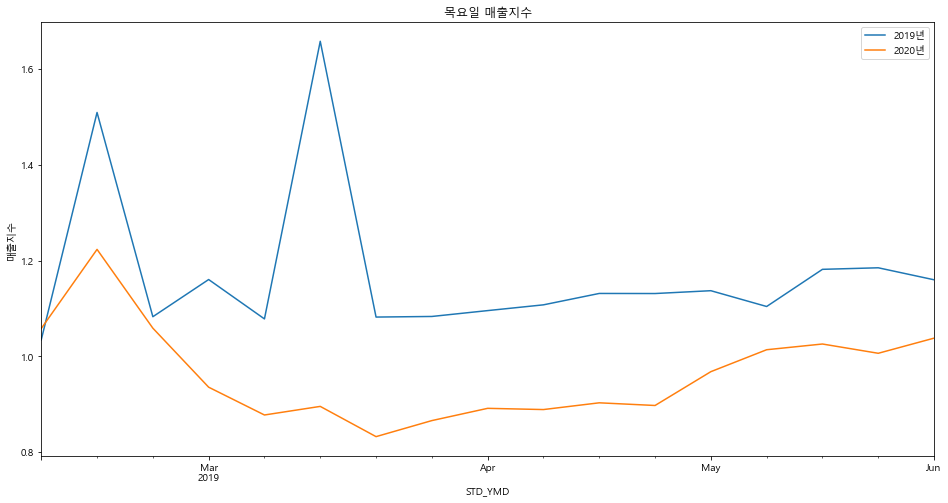

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
last_thu.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_thu.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('목요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

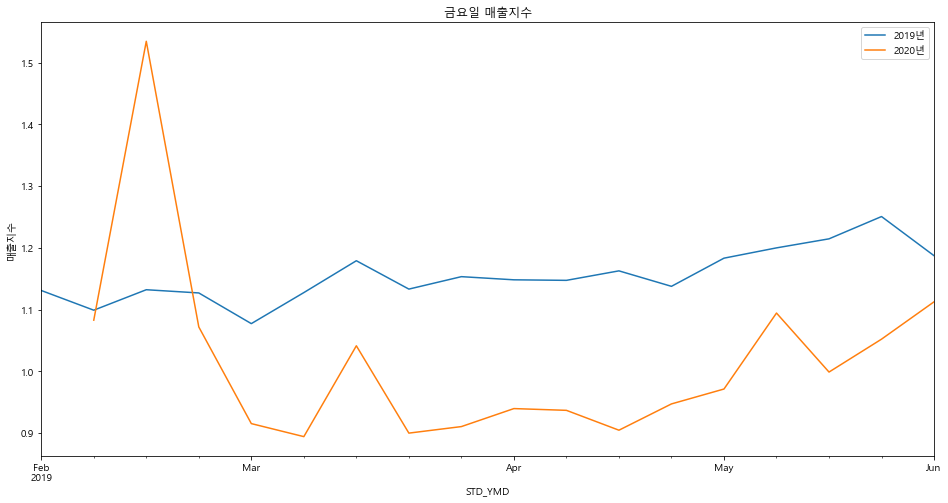

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
last_fri.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_fri.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('금요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

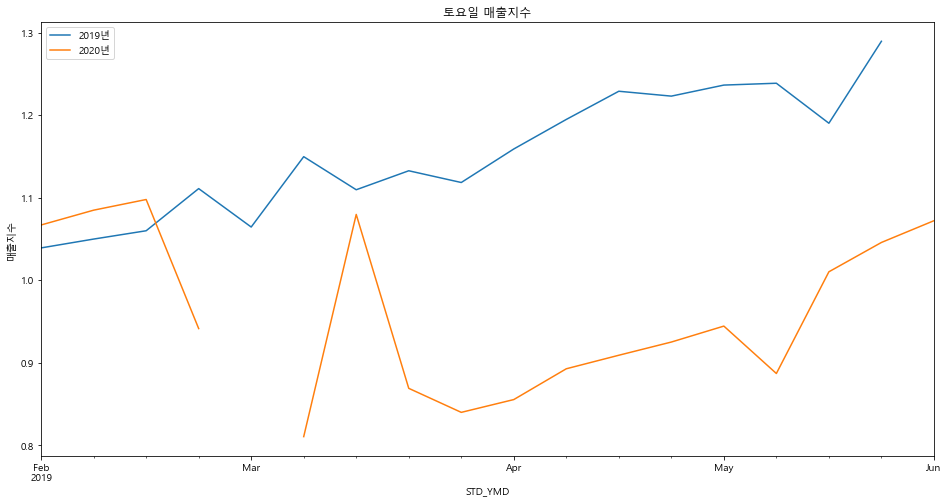

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
last_sat.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_sat.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('토요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

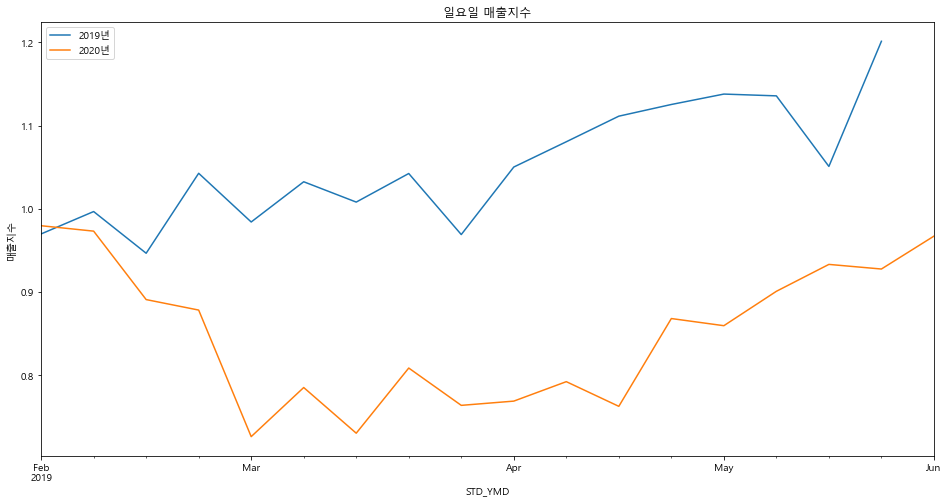

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
last_sun.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)
this_sun.groupby(pd.Grouper(freq='W')).mean().plot(ax=ax)

ax.set_title('일요일 매출지수')
ax.set_ylabel('매출지수')
#ax.set_xticks(pd.date_range('2019-02-15', '2019-05-31', freq='7D'))
#ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May'])

plt.legend(['2019년', '2020년'])

plt.show()

In [40]:
last.head()

STD_YMD
2019-02-05    0.989785
2019-02-05    1.658221
2019-02-05    0.984660
2019-02-05    1.013661
2019-02-05    1.241757
Name: AMT_IND, dtype: float64

In [41]:
index.head()

,GU_NM,HDONG_NM,AMT_IND,DAW
STD_YMD,,,,
2019-02-01,대구 수성구,고산1동,1.064336,Friday
2019-02-01,대구 수성구,고산2동,1.076418,Friday
2019-02-01,대구 수성구,고산3동,0.856071,Friday
2019-02-01,대구 수성구,두산동,0.724868,Friday
2019-02-01,대구 수성구,만촌1동,1.155728,Friday


2019년 요일별 매출지수

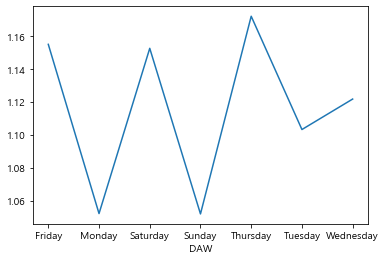

In [57]:
index.query('index <= "2019-05-31"').groupby(['DAW'])['AMT_IND'].mean().plot()

2020년 요일별 매출지수

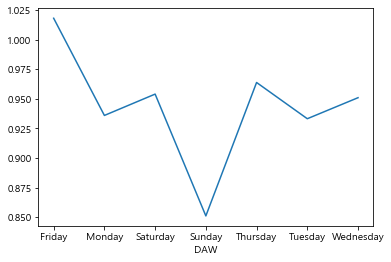

In [58]:
index.query('index >= "2020-02-01"').groupby(['DAW'])['AMT_IND'].mean().plot()

2019년 대구 요일별 매출지수

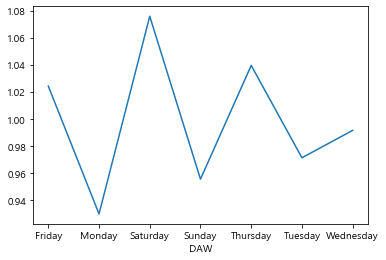

In [61]:
index.query('index <= "2019-05-31"').query('GU_NM == "대구 수성구" or GU_NM =="대구 중구"').groupby(['DAW'])['AMT_IND'].mean().plot()

## 물류

In [19]:
delivery = pd.read_excel('../data/05_CJ_Olive_Networks/cj_dataset.xlsx')
delivery = eda.delivery_preprocessing(delivery)
print(delivery.shape)
delivery.head()

(156571, 5)


,STD_YMD,GU_NM,HDONG_NM,GD_NM,INV_CNT
0,2019-02-01,서울 중구,동화동,도서/음반,16
1,2019-02-01,서울 중구,신당동,가구/인테리어,4
2,2019-02-01,대구 중구,성내1동,가구/인테리어,1
3,2019-02-01,대구 중구,남산2동,도서/음반,6
4,2019-02-01,대구 수성구,고산3동,디지털/가전,21


## 질병

### 유동인구 + 카드매출

회현동은 외국인 이용금액이 전체 이용금액에서차지하는 비중이 높으므로 일단은 분석에서 제외

In [20]:
rg= pd.merge(resid, age, on=['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD'],
             how='left')

In [21]:
rg = rg.query('HDONG_NM != "회현동"')

In [22]:
rg = rg.set_index('STD_YMD')
rg

,GU_NM,HDONG_NM,SEX_CD,AGE_CD,USE_CNT,USE_AMT,POP_CNT
STD_YMD,,,,,,,
2019-02-01,대구 수성구,고산1동,F,20,634,8206,8940.65
2019-02-01,대구 수성구,고산1동,F,25,680,11416,3686.51
2019-02-01,대구 수성구,고산1동,F,30,502,10644,3505.06
2019-02-01,대구 수성구,고산1동,F,35,691,15472,5378.35
2019-02-01,대구 수성구,고산1동,F,40,983,23233,6873.14
...,...,...,...,...,...,...,...
2020-05-31,서울 중구,황학동,M,45,801,32938,1402.03
2020-05-31,서울 중구,황학동,M,50,885,36143,1548.26
2020-05-31,서울 중구,황학동,M,55,645,24650,1499.27


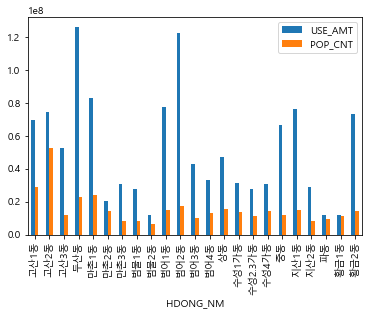

In [23]:
rg.query('GU_NM == "대구 수성구"').groupby('HDONG_NM')[['USE_AMT', 'POP_CNT']].sum().plot(kind='bar')
plt.show()

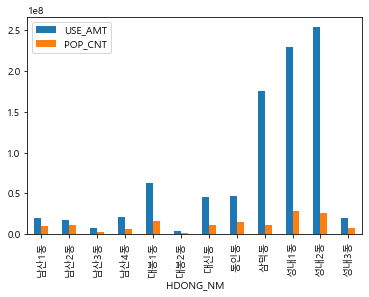

In [31]:
rg.query('GU_NM == "대구 중구"').groupby('HDONG_NM')[['USE_AMT', 'POP_CNT']].sum().plot(kind='bar')
plt.show()

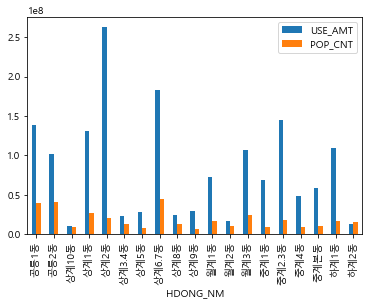

In [32]:
rg.query('GU_NM == "서울 노원구"').groupby('HDONG_NM')[['USE_AMT', 'POP_CNT']].sum().plot(kind='bar')
plt.show()

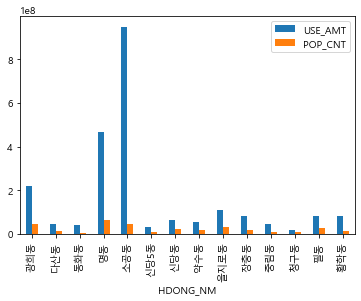

In [33]:
rg.query('GU_NM == "서울 중구"').groupby('HDONG_NM')[['USE_AMT', 'POP_CNT']].sum().plot(kind='bar')
plt.show()

In [24]:
rg.query('GU_NM == "대구 중구"')[['USE_AMT', 'POP_CNT']].corr()

,USE_AMT,POP_CNT
USE_AMT,1.00000,0.60598
POP_CNT,0.60598,1.00000


### 유동인구 + 카드매출 + 매출지수

In [25]:
sgx = pd.merge(sales, tr_age).merge(index)
sgx

,STD_YMD,GU_NM,HDONG_NM,USE_CNT,USE_AMT,POP_CNT,AMT_IND
0,2019-02-01,대구 수성구,고산1동,15389,412037,133361.08,1.064336
1,2019-02-01,대구 수성구,고산2동,11548,387103,254912.57,1.076418
2,2019-02-01,대구 수성구,고산3동,12774,336823,57764.08,0.856071
3,2019-02-01,대구 수성구,두산동,15480,683605,125647.42,0.724868
4,2019-02-01,대구 수성구,만촌1동,12039,544981,132277.61,1.155728
...,...,...,...,...,...,...,...
14455,2020-05-31,서울 중구,중림동,7713,209653,21982.16,1.595038
14456,2020-05-31,서울 중구,청구동,4061,67182,15985.86,1.389184
14457,2020-05-31,서울 중구,필동,10271,213727,53756.05,0.714265
14458,2020-05-31,서울 중구,황학동,12780,389885,28761.22,1.134190


### 유동인구 + 카드매출 + 매출지수 + 감염병

In [26]:
sgx

,STD_YMD,GU_NM,HDONG_NM,USE_CNT,USE_AMT,POP_CNT,AMT_IND
0,2019-02-01,대구 수성구,고산1동,15389,412037,133361.08,1.064336
1,2019-02-01,대구 수성구,고산2동,11548,387103,254912.57,1.076418
2,2019-02-01,대구 수성구,고산3동,12774,336823,57764.08,0.856071
3,2019-02-01,대구 수성구,두산동,15480,683605,125647.42,0.724868
4,2019-02-01,대구 수성구,만촌1동,12039,544981,132277.61,1.155728
...,...,...,...,...,...,...,...
14455,2020-05-31,서울 중구,중림동,7713,209653,21982.16,1.595038
14456,2020-05-31,서울 중구,청구동,4061,67182,15985.86,1.389184
14457,2020-05-31,서울 중구,필동,10271,213727,53756.05,0.714265
14458,2020-05-31,서울 중구,황학동,12780,389885,28761.22,1.134190


### 유동인구 + 카드매출 + 송장건수

In [27]:
tr_delivery = delivery.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['INV_CNT'] \
                      .sum().reset_index()

In [28]:
sgy = pd.merge(sales, tr_age).merge(tr_delivery)
sgy

,STD_YMD,GU_NM,HDONG_NM,USE_CNT,USE_AMT,POP_CNT,INV_CNT
0,2019-02-01,대구 수성구,고산1동,15389,412037,133361.08,333
1,2019-02-01,대구 수성구,고산2동,11548,387103,254912.57,220
2,2019-02-01,대구 수성구,고산3동,12774,336823,57764.08,348
3,2019-02-01,대구 수성구,두산동,15480,683605,125647.42,137
4,2019-02-01,대구 수성구,만촌1동,12039,544981,132277.61,186
...,...,...,...,...,...,...,...
16564,2020-05-31,서울 중구,중림동,7713,209653,21982.16,150
16565,2020-05-31,서울 중구,청구동,4061,67182,15985.86,106
16566,2020-05-31,서울 중구,필동,10271,213727,53756.05,58
16567,2020-05-31,서울 중구,황학동,12780,389885,28761.22,149


### 유동인구 + TOPIC

In [29]:
tl = pd.merge(topic, hd_flow)
tl = tl.set_index('STD_YMD')
print(tl.shape)
tl.head()

(280, 4)


,GU_NM,HDONG_NM,TOPIC,POP_CNT
STD_YMD,,,,
2019-02-01,서울 중구,소공동,"장관,기념식,창간,롯데호텔,뷔페",5926560.345
2019-02-01,서울 중구,회현동,"회현동,서울역,도시재생,윤동주,일제강점기",7799199.960
2019-02-01,서울 중구,명동,"생활유산,열쇠고리,신세계백화점,리뉴얼,관광객",9344658.395
2019-02-01,서울 중구,필동,"저작권,영남상생포럼,자유한국장,지적,그랜드호텔",3474740.560
2019-02-01,서울 중구,장충동,"빵집,태극당,신라호텔,세관,감사원",2262422.520


In [30]:
tl['2020-5'].query('"대구 수성구" in GU_NM').sort_values(by='POP_CNT', 
                                                        ascending=False)[:5]

,GU_NM,HDONG_NM,TOPIC,POP_CNT
STD_YMD,,,,
2020-05-01,대구 수성구,고산동,"회복세,지자체,방문자제,대기업,취업제한",1.191514e+07
2020-05-01,대구 수성구,범어동,"코로나19,확진자,주거시설,학부모,금감원장",6.866484e+06
2020-05-01,대구 수성구,만촌동,"이용수,정의기억연대,위안부,윤미향,더불어민주당",5.922134e+06
2020-05-01,대구 수성구,수성동,"위안화,전산망,윤석헌,자회사,남광토건",4.675632e+06
2020-05-01,대구 수성구,황금동,"문화도시,수성못,공연거리,행정복지센터,지자체",2.977744e+06
